# Introduction to USGS Landsat surface reflectance

**Background:** Surface reflectance products from three Landsat satellites (**Landsat 5, 7 and 8**) are available for access through through the CSIRO DC on AWS and the GA DEA at NCI.  There are several different forms of Surface Reflectance product made available (eg. USGS Surface Reflectance, Geoscience Australia Digital Earth Australia NBAR and NBART products).

To reduce storage needs for training the CDC Lte only includes sample Landsat 8 data. The code snippets in this doc will retrieve, modify and plot the data for `ls8_usgs_sr_scene`. Aside the product name and the differing number of `measurements` (satellite bands), the exact same code will work with the other satellites (and as you will see, any product loaded in the datacube).

**What does this document do?**

- Show how to use datacube to retrieve Landsat data for various temporal and spatial extents
- Plot individual Landsat bands
- Plot multiple Landsat bands as a true colour image
- Plot multiple Landsat bands as a false colour image
- Demonstrate how to compute and plot simple remote sensing band indices

**Authors**: 

Ported to CSIRO Data Cube by CSIRO.

This notebook is derived from the Geoscience Australia, Digital Earth Australia Landsat example notebook developed by: Robbi Bishop-Taylor, Arapaut Sivaprasad, Claire Krause, Bex Dunn

## About Landsat 

"Landsat represents the world's longest continuously acquired collection of space-based moderate-resolution land remote sensing data. Four decades of imagery provides a unique resource for those who work in agriculture, geology, forestry, regional planning, education, mapping, and global change research. Landsat images are also invaluable for emergency response and disaster relief." [[1](#References)] 

"In the mid-1960s an ambitious effort to develop and launch the first civilian Earth observation satellite was started. The goal was achieved on July 23, 1972, with the launch of the Earth Resources Technology Satellite (ERTS-1), which was later renamed Landsat 1. The launches of Landsat 2, Landsat 3, and Landsat 4 followed in 1975, 1978, and 1982, respectively. When Landsat 5 was launched in 1984, no one could have predicted that the satellite would continue to deliver high quality, global data of Earth's land surfaces for 28 years and 10 months until its retirement in June, 2013. Landsat 6, however, failed to achieve orbit in 1993. Landsat 7 was successfully launched in 1999 and, along with Landsat 8 launched in 2013, continues to provide daily global data. Landsat 9 is planned to be launched in late 2020." [[2](#References)]


### Available bands
The sensors on the Landsats are different and collect reflected radiance in various spectral wavelengths. These are called bands. Details about the bands for satellites 5, 7 and 8 can be found at [[3](#References)], [[5](#References)] and [[6](#References)], respectively. The following bands are included in the DEA archive: band names to be used in code, when retrieving the data, are given in brackets.

- **Landsat 5 and 7:**
    - Excludes Landsat 5 Thematic Mapper (TM) thermal band and Multispectral Scanner (MSS) bands, and Landsat 7 Enhanced Thematic Mapper Plus (ETM+) thermal band and panchromatic band    
    - Includes the following Landsat 5 TM and Landsat 7 ETM+ bands:  
        - Band 1: blue (`blue`)
        - Band 2: green (`green`)
        - Band 3: red (`red`)
        - Band 4: near-infrared (`nir`)
        - Band 5: shortwave infrared 1 (`swir1`)
        - Band 7: shortwave infrared 2 (`swir2`)
- **Landsat 8:**
    - Excludes the Operational Land Imager (OLI) panchromatic or cirrus bands, and Thermal Infrared Sensor (TIRS) bands
    - Includes the following Operational Land Imager (OLI) bands:
        - Band 1: coastal aerosol (`coastal_aerosol`)         
        - Band 2: blue (`blue`)
        - Band 3: green (`green`)
        - Band 4: red (`red`)
        - Band 5: near-infrared (`nir`)
        - Band 6: shortwave infrared 1 (`swir1`)
        - Band 7: shortwave infrared 2 (`swir2`)




### Landsat 7 Scan Line Corrector failure

"The Scan Line Corrector (SLC) is an electro-optical mechanism composed of two parallel mirrors set at an angle on a shaft. The SLC is positioned behind the primary optics and compensates for the along-track motion of the spacecraft occurring during an active SMA cross-track scan. As a result, a rectilinear scan pattern is produced using the SLC instead of the zigzag pattern that would be produced without it. The SLC failed for Landsat 7 on May 31, 2003. Without an operating SLC, the ETM+ line of sight now traces a zig-zag pattern along the satellite ground track (see the figure above) resulting in wedge shaped scan-to-scan gaps (and alternating overlap areas) which increase in magnitude away from nadir. Despite the SLC failure, Landsat 7 ETM+ is still capable of acquiring useful image data with the SLC turned off (SLC-off), particularly within the central portion of any given scene." [[8](#References)]

The top panel in the figure below shows how Landat 7 imagery appears prior to the May 31 2003 SLC failure (i.e. Landsat 7 SLC-on). The bottom panel shows the same area after the SLC failed (i.e. Landsat 7 SLC-off), with obvious diagonal striping that covers approximately 22% of the scene. This striping will be present in all post-May 31 2003 data in the archive. For certain applications, it may be best to completely exclude post post-May 31 2003 imagery from analyses.

![Figure 3. Scan line corrected image.](../Supplementary_data/Images/SLC_comparison.jpg)

## Retrieving Landsat data
The following code demonstrates how to load Landsat data using the Open Data Cube API, plot the data, and perform simple analyses (i.e. generating remote sensing band indices).

### Import modules

In [1]:
%matplotlib notebook
import sys
import warnings
import datacube
import matplotlib.pyplot as plt
from datacube.storage import masking


/home/jovyan/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Available Landsat products
The `list_products` method in the Datacube class displays the names and details of all supported products in this datacube. For example, `ls8_usgs_sr_scene` provides  surface reflectance data generated using Landsat 8 imagery. Just because a datacube can support a product doesn't mean it contains data for that product. The CDC Lte environment includes Landsat 8 data only be default.

In [2]:
# Connect to a datacube
dc = datacube.Datacube(app='Intro to Landsat')

# List metadata for all Landsat NBAR and NBART products available in DEA
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type', 'crs', 'resolution', 'spatial_dimensions']
dc_products[dc_products['name'].str.contains("usgs_sr_scene")][display_columns].set_index('name')

,description,product_type,crs,resolution,spatial_dimensions
name,,,,,
ls8_usgs_sr_scene,Landsat 8 USGS Collection 1 Higher Level SR sc...,LaSRC,NaN,NaN,NaN


### Specify a *query* with coordinates and date range

- **lat/lon:** Latitude and longitude of the area. e.g. Canberra = `'lat': (-35.25, -35.35), 'lon': (149.05, 149.17)`
- **time:** Date range to fetch the scenes. The approximate time between two scenes is 16 days. If there is a location near a swath boundary, it may be captured in two passes and so there could be two images within the 16 day period.
    - You must know the date(s) for which data is available for each satellite/product, so that the query can be specified correctly. 

In [3]:
# Define temporal and spatial extents to pass to `dc.load` for the data extraction:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17),
         'time':('2017-09-01', '2017-09-15'),
         'output_crs': 'epsg:3577',
         'resolution': (-30,30)}

### Load Landsat data
In this example we will load USGS SR data from the Landsat 8 satellite. Sometimes multiple scenes are acquired by a satellite on the same day. We want to group these together, and will use `group_by='solar_day'` to do this. To load in the data, we use our query above to provide a spatial and temporal extraction range.

`dc.load` returns an **xarray** object, which has two core data structures:

- `DataArray` is a labeled, N-dimensional array.
- `Dataset` is a multi-dimensional, in-memory array database. It is a dict-like container of DataArray objects aligned along any number of shared dimensions.

The available Landsat bands are listed under `Data variables`. Valid surface reflectance values for each of the Landsat bands are expressed as **16-bit integers scaled between 0 and 10000.**
For USGS Surface Reflectance data there are values though that can be negative or > 10000 due to the way Surface Refllectance values are calculated. The USGS Landsat product specification tells you the _Range_ expected for each band and the _Valid Range_ for each band. No-data value are also present in the data where the satellite didn't collect data. These are marked as -9999 in USGS Surface Reflectance data. A little later we'll be cleaning up these apsects of the data so they don't impact the processing.

In [4]:
# Load data for the specified query extent using `dc.load`:
ds = dc.load(product='ls8_usgs_sr_scene', **query, group_by='solar_day')
ds

<xarray.Dataset>
Dimensions:          (time: 2, x: 410, y: 417)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) int16 187 89 69 257 271 431 237 212 215 ...
    blue             (time, y, x) int16 233 277 382 518 447 489 285 321 328 ...
    green            (time, y, x) int16 481 567 689 806 726 785 513 630 523 ...
    red              (time, y, x) int16 580 548 751 1063 923 809 591 650 604 ...
    nir              (time, y, x) int16 2115 2291 2447 2283 2250 2511 1983 ...
    swir1            (time, y, x) int16 1357 1516 1891 1768 1467 2189 1472 ...
    swir2            (time, y, x) int16 956 1010 1317 1277 1077 1607 1076 ...
    pixel_qa         (time, y, x) uint16 322 322 322 322 322 322 322 322 322 ...
    sr_aerosol       (time, y, x) uint8

### Remove nodata values
It is essential to remove `-9999` nodata values prior to analysing or plotting Landsat imagery. You can do with by setting all nodata values to `NaN` (Not a Number) using the `mask_invalid_data` function. Whilst we are at it we'll set values outside the _Valid Range_ to `NaN` as well. Sounds simple enough...and it _mostly_ is.

There are two things though to take account of:
1. There is something about `NaN` that isn't immediately obvious `NaN` has a data type of `float64`. Currently the `Data variables` for `reflectance` bands is `int16`. You can see this in the print out of the `Dataset` above just after where it says `(time, y, x)`. If we are going to set these nodata and invalid range values to `NaN` we'll have to convert the reflectance bands to be `float64`.
2. If we simply performs operations on the `Dataset` (`ds`) then ALL `Data Variables` will have this computation performed and all our `bit_flags` will be turned into `float64` as well, which is not what we want.

The good news is `xarray.Dataset` supports the ability to restrict which `Data variables` are being used simply be referring to them, and we can do so in groups. If you already know in advance which `Data variables` are `reflectance` bands then you could just make a list of their names and use that. We're not going to make that assumption in this notebook. Instead we're going to ask the datacube to tell us. We've already seen how to `datacube.list_measurements()` so we can use that to get the appropriate data variables. Once we have that we can using `masking.mask_invalid_data()` and `xarray.where()` to assign our `NaN`. Last but not least we can place the result straight back into our original `Dataset` ds for future processing (you could of course just use the resulting produced but as you will see the result doesn't include the pixel quality `data variables` and we will want those later.

If that sounds a bit messy be assured its only a few lines of code and we'll show you that first with just before and after views. Then we'll do it all again by reloading the dataset and step it out so you can see the transformation occuring which will make this look worse than it really is. It's important though because it shows how what you do impacts the data which will be important later when you write your programs.



In [5]:
# Your head is probably exploding after that explanation so let's just show the before data again by reloading it and displaying the array
# this is exactly the same as the previous cell <grin>
ds = dc.load(product='ls8_usgs_sr_scene', **query, group_by='solar_day')
ds



<xarray.Dataset>
Dimensions:          (time: 2, x: 410, y: 417)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) int16 187 89 69 257 271 431 237 212 215 ...
    blue             (time, y, x) int16 233 277 382 518 447 489 285 321 328 ...
    green            (time, y, x) int16 481 567 689 806 726 785 513 630 523 ...
    red              (time, y, x) int16 580 548 751 1063 923 809 591 650 604 ...
    nir              (time, y, x) int16 2115 2291 2447 2283 2250 2511 1983 ...
    swir1            (time, y, x) int16 1357 1516 1891 1768 1467 2189 1472 ...
    swir2            (time, y, x) int16 956 1010 1317 1277 1077 1607 1076 ...
    pixel_qa         (time, y, x) uint16 322 322 322 322 322 322 322 322 322 ...
    sr_aerosol       (time, y, x) uint8

Notice all the Data variables are of type `int16`.

Now lets:
1. find the measurements that are surface reflectance and get an index of their `Data variable` names
1. Asign the `NaN`s
1. Put the result back into the original `Dataset` `ds`

In [6]:
# Get the measurements from the datacube
measurements = dc.list_measurements()
reflectance_measurements = measurements[measurements['units'] == 'reflectance']
dv_names = reflectance_measurements.index.get_level_values('measurement')

# Set all nodata pixels to `NaN` for the data variables in dv_names
ds_nans = masking.mask_invalid_data(ds[dv_names])
# Set all invalid to `NaN` - valid range for USRS SR is 0 to 10000
ds_nans = ds_nans.where((ds_nans >= 0) & (ds_nans<=10000))

ds.update(ds_nans,inplace=True)
ds

<xarray.Dataset>
Dimensions:          (time: 2, x: 410, y: 417)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 187.0 89.0 69.0 257.0 271.0 431.0 ...
    blue             (time, y, x) float64 233.0 277.0 382.0 518.0 447.0 ...
    green            (time, y, x) float64 481.0 567.0 689.0 806.0 726.0 ...
    red              (time, y, x) float64 580.0 548.0 751.0 1.063e+03 923.0 ...
    nir              (time, y, x) float64 2.115e+03 2.291e+03 2.447e+03 ...
    swir1            (time, y, x) float64 1.357e+03 1.516e+03 1.891e+03 ...
    swir2            (time, y, x) float64 956.0 1.01e+03 1.317e+03 1.277e+03 ...
    pixel_qa         (time, y, x) uint16 322 322 322 322 322 322 322 322 322 ...
    sr_aerosol       (time, y, x) uint8 228 228 2

Compare this with the original above and you can see the `int16` for only the `reflectance` measurements have been changed to `float64`. They've also had the `NaN`s set but the first few elements don't contain that, trust us, it did that!

Let's look at some of the iterim results so you can see more clearly what is happening

In [7]:
# dv_names: this is an Index object with just the reflectance bands in it
dv_names

Index(['coastal_aerosol', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2'], dtype='object', name='measurement')

In [8]:
# you use dv_names to restrict the Data variables that are accessed when performing operations on an xarray.Dataset
ds[dv_names]

<xarray.Dataset>
Dimensions:          (time: 2, x: 410, y: 417)
Coordinates:
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 187.0 89.0 69.0 257.0 271.0 431.0 ...
    blue             (time, y, x) float64 233.0 277.0 382.0 518.0 447.0 ...
    green            (time, y, x) float64 481.0 567.0 689.0 806.0 726.0 ...
    red              (time, y, x) float64 580.0 548.0 751.0 1.063e+03 923.0 ...
    nir              (time, y, x) float64 2.115e+03 2.291e+03 2.447e+03 ...
    swir1            (time, y, x) float64 1.357e+03 1.516e+03 1.891e+03 ...
    swir2            (time, y, x) float64 956.0 1.01e+03 1.317e+03 1.277e+03 ...
Attributes:
    crs:      epsg:3577

In [9]:
#for easy comparison lets show ds wihtout the indexing occuring, as you can see it is still intact
ds

<xarray.Dataset>
Dimensions:          (time: 2, x: 410, y: 417)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 187.0 89.0 69.0 257.0 271.0 431.0 ...
    blue             (time, y, x) float64 233.0 277.0 382.0 518.0 447.0 ...
    green            (time, y, x) float64 481.0 567.0 689.0 806.0 726.0 ...
    red              (time, y, x) float64 580.0 548.0 751.0 1.063e+03 923.0 ...
    nir              (time, y, x) float64 2.115e+03 2.291e+03 2.447e+03 ...
    swir1            (time, y, x) float64 1.357e+03 1.516e+03 1.891e+03 ...
    swir2            (time, y, x) float64 956.0 1.01e+03 1.317e+03 1.277e+03 ...
    pixel_qa         (time, y, x) uint16 322 322 322 322 322 322 322 322 322 ...
    sr_aerosol       (time, y, x) uint8 228 228 2

In [10]:
# masking.mask_invalid_data() uses ds.where() under the hood so lets demonstrate how running this impacts that data.
# Since we can't see in the first few array elements any nan values let's modify the lower limit of the where clause so we get
# to see a few in the first few elements. There are a few values < 188 in the coastal_aerosol Data variables, so lets use 188
# as the lower bound
ds_nans = ds[dv_names].where((ds[dv_names] >= 188) & (ds[dv_names]<=10000))
ds_nans

<xarray.Dataset>
Dimensions:          (time: 2, x: 410, y: 417)
Coordinates:
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 nan nan nan 257.0 271.0 431.0 ...
    blue             (time, y, x) float64 233.0 277.0 382.0 518.0 447.0 ...
    green            (time, y, x) float64 481.0 567.0 689.0 806.0 726.0 ...
    red              (time, y, x) float64 580.0 548.0 751.0 1.063e+03 923.0 ...
    nir              (time, y, x) float64 2.115e+03 2.291e+03 2.447e+03 ...
    swir1            (time, y, x) float64 1.357e+03 1.516e+03 1.891e+03 ...
    swir2            (time, y, x) float64 956.0 1.01e+03 1.317e+03 1.277e+03 ...
Attributes:
    crs:      epsg:3577

Couple of things to note in this:
1. `ds.where()` made a _copy_ of the `ds` data
1. It copies only the Data variables identified by `dv_names` so there are no `pixel_qa` etc bit_flags

`d`s itself is unchanged which you can see below if you view `ds` again. "Look mum no NaNs!" said coastal_aerosol

This is why we need to `ds.update(ds_nans,inplace=True)` if we want to update the original `ds` and keep our reflectance data and pixel quality together.


In [11]:
# The .where() call made a copy of the data when it did this.
ds

<xarray.Dataset>
Dimensions:          (time: 2, x: 410, y: 417)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 187.0 89.0 69.0 257.0 271.0 431.0 ...
    blue             (time, y, x) float64 233.0 277.0 382.0 518.0 447.0 ...
    green            (time, y, x) float64 481.0 567.0 689.0 806.0 726.0 ...
    red              (time, y, x) float64 580.0 548.0 751.0 1.063e+03 923.0 ...
    nir              (time, y, x) float64 2.115e+03 2.291e+03 2.447e+03 ...
    swir1            (time, y, x) float64 1.357e+03 1.516e+03 1.891e+03 ...
    swir2            (time, y, x) float64 956.0 1.01e+03 1.317e+03 1.277e+03 ...
    pixel_qa         (time, y, x) uint16 322 322 322 322 322 322 322 322 322 ...
    sr_aerosol       (time, y, x) uint8 228 228 2

## Plotting Landsat data

### Plot single Landsat bands 
Xarray objects contain built-in methods for plotting single bands. For example, we can plot the Landsat 8 `nir` (near-infrared) band for each timestep:

<IPython.core.display.Javascript object>


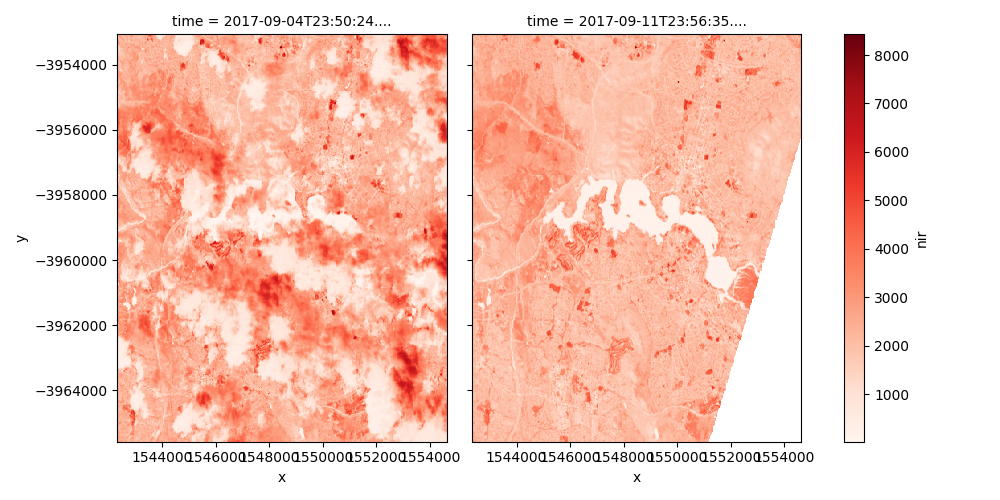

In [12]:
# Make a plot with one column for each time-step:
ds.nir.plot(col='time', figsize=(10, 5), cmap = 'Reds');  # This also works: ds['nir'].plot(col='time')

As you can see accessing the `Data variables` is straightforward using their name. This is the `xarray` labelled array implementation making your EO life easier. Also notice that since we didn't limit the `time` dimension the plot includes both times, and we asked for these to be in columns (2 times so 2 columns)

### Creating a 'true colour' image using three bands
We can also plot combinations of multiple bands as a colour RGB image by converting the xarray dataset to a three band data array, using `.isel(time=1)` to pull out a single time-step to plot, then using the `.plot.imshow` method to plot.

By specifying the `red`, `green` and `blue` bands, we can produce a ['true colour' plot](https://crisp.nus.edu.sg/~research/tutorial/opt_int.htm) that approximates how the landscape would appear to the human eye. Note however that below we use the `robust=True` argument to remove extreme values and result in a colour-enhanced image:

<IPython.core.display.Javascript object>


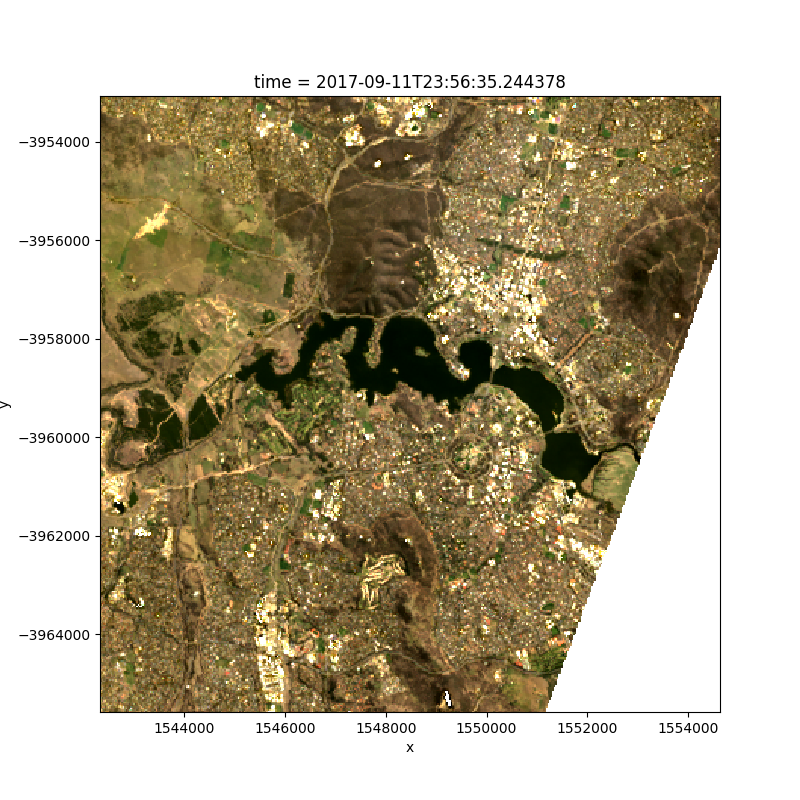

In [13]:
ds[['red', 'green', 'blue']].isel(time=1).to_array().plot.imshow(robust=True, figsize=(8, 8))

### Creating a 'false colour' image using three bands
This plot uses the SWIR and NIR bands to accentuate the presence of water or vegetation in the landscape:

<IPython.core.display.Javascript object>


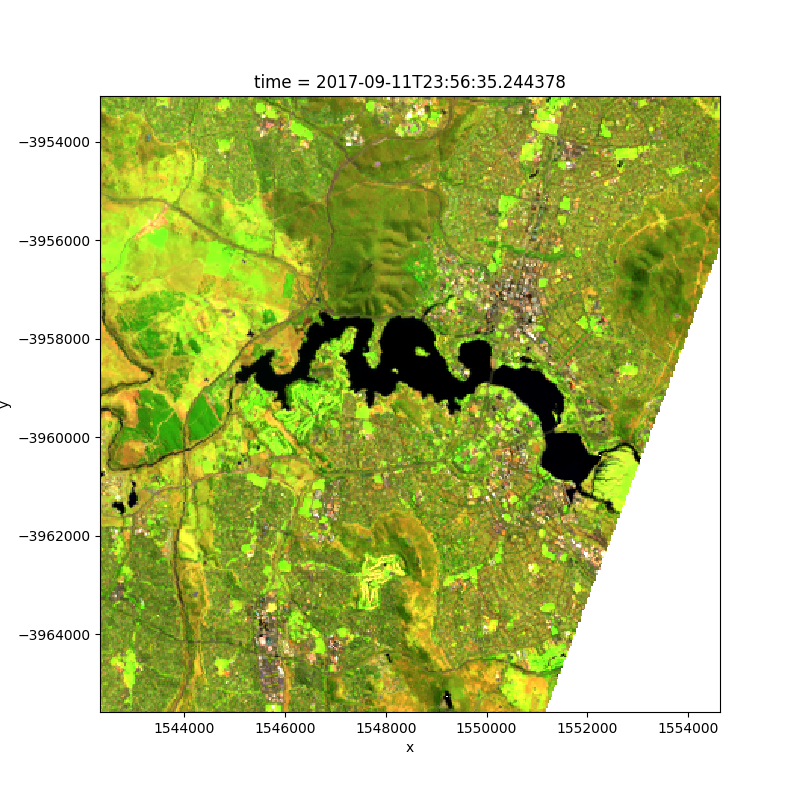

In [14]:
ds[['swir1', 'nir', 'green']].isel(time=1).to_array().plot.imshow(robust=True, figsize=(8, 8))

## Computing band indices

Bands from Landsat surface reflectance products can be combined to compute simple remote sensing indices that provide insights into different aspects of the observed landscape. For example, we can calculate the Normalized Difference Water Index (NDWI), which has high values where a pixel is likely to be open water (e.g. NDWI > 0, or red colours below):

In [15]:
# Compute NDWI using the formula (green - nir) / (green + nir). This will calculate 
# NDWI for every time-step in the dataset:
ds_ndwi = (ds.green - ds.nir) / (ds.green + ds.nir)
ds_ndwi 

<xarray.DataArray (time: 2, y: 417, x: 410)>
array([[[-0.62943 , -0.603219, ..., -0.578414, -0.55304 ],
        [-0.588629, -0.62948 , ..., -0.537263, -0.516207],
        ...,
        [-0.370139, -0.421973, ..., -0.361305, -0.374131],
        [-0.450067, -0.450825, ..., -0.371079, -0.373925]],

       [[-0.539369, -0.519305, ..., -0.585766, -0.594392],
        [-0.567609, -0.57101 , ..., -0.55377 , -0.558007],
        ...,
        [-0.344828, -0.421307, ...,       nan,       nan],
        [-0.395374, -0.448886, ...,       nan,       nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...

As you can see you `xarray` allows you to perform math directly on the entire array (both space and time) and use the band names. All very neat and logical.

We will probably want to do further processing on the NDWI result, we can either do that using the separate `ds_ndwi` variable or we can add this to our dataset object as an additional `Data variable`. It's easy to do, we just give it a label and assign the result.

In [16]:
# We can now add this back into our dataset as a new data variable:
ds["NDWI"] = ds_ndwi
ds

<xarray.Dataset>
Dimensions:          (time: 2, x: 410, y: 417)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 187.0 89.0 69.0 257.0 271.0 431.0 ...
    blue             (time, y, x) float64 233.0 277.0 382.0 518.0 447.0 ...
    green            (time, y, x) float64 481.0 567.0 689.0 806.0 726.0 ...
    red              (time, y, x) float64 580.0 548.0 751.0 1.063e+03 923.0 ...
    nir              (time, y, x) float64 2.115e+03 2.291e+03 2.447e+03 ...
    swir1            (time, y, x) float64 1.357e+03 1.516e+03 1.891e+03 ...
    swir2            (time, y, x) float64 956.0 1.01e+03 1.317e+03 1.277e+03 ...
    pixel_qa         (time, y, x) uint16 322 322 322 322 322 322 322 322 322 ...
    sr_aerosol       (time, y, x) uint8 228 228 2

At this point because of the way we did it we actually have two copies of the ndwi result: `ds_ndwi` and `ds["NDWI"]`.

You can do this in a single step as follows:

In [17]:
ds["NDWI"] = (ds.green - ds.nir) / (ds.green + ds.nir)
ds

<xarray.Dataset>
Dimensions:          (time: 2, x: 410, y: 417)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 187.0 89.0 69.0 257.0 271.0 431.0 ...
    blue             (time, y, x) float64 233.0 277.0 382.0 518.0 447.0 ...
    green            (time, y, x) float64 481.0 567.0 689.0 806.0 726.0 ...
    red              (time, y, x) float64 580.0 548.0 751.0 1.063e+03 923.0 ...
    nir              (time, y, x) float64 2.115e+03 2.291e+03 2.447e+03 ...
    swir1            (time, y, x) float64 1.357e+03 1.516e+03 1.891e+03 ...
    swir2            (time, y, x) float64 956.0 1.01e+03 1.317e+03 1.277e+03 ...
    pixel_qa         (time, y, x) uint16 322 322 322 322 322 322 322 322 322 ...
    sr_aerosol       (time, y, x) uint8 228 228 2

Is it better to have a separate variable or add another to the existing `Dataset`?
The answer really depends on what you are trying to do and how you think about data.

### Plotting a single data variable or band
Newly created data variables (like `NDWI` above) can be plotted in exactly the same way as individual Landsat bands:

<IPython.core.display.Javascript object>


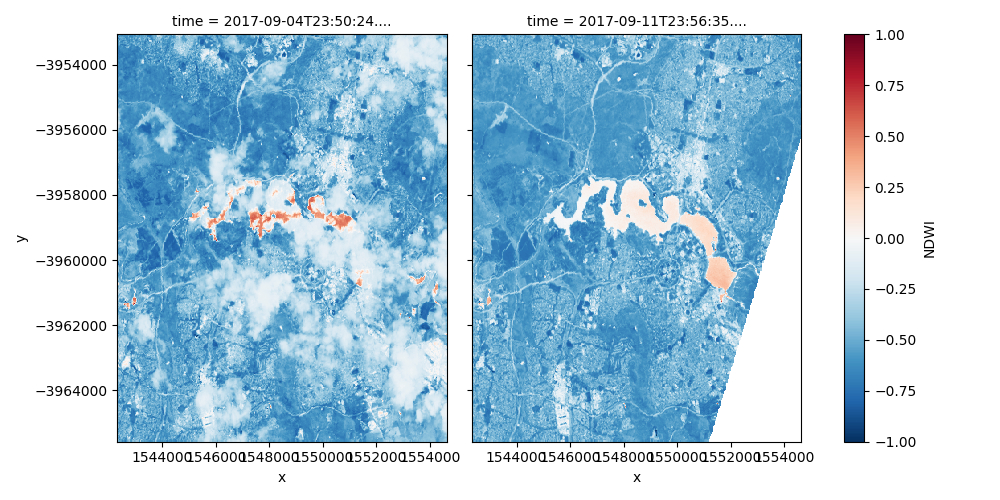

In [18]:
# First, we select the variable we want ('NDWI'), and then make a 
# plot with one column for each time-step:
ds.NDWI.plot(col='time', figsize=(10, 5)); 

There are thousands of different band indices available; for example, the Normalized Difference Vegetation Index (NDVI) which has high values for pixels containing vegetation:

<IPython.core.display.Javascript object>


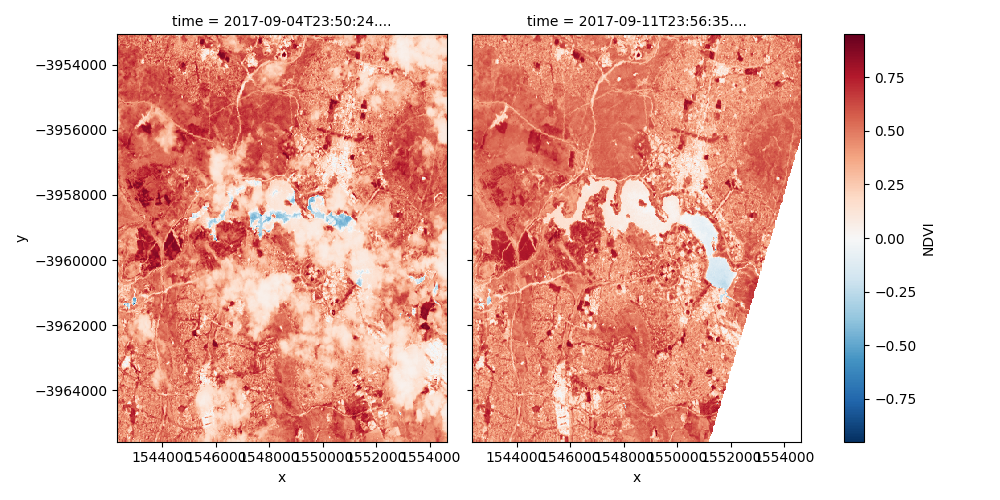

In [19]:
# Compute NDVI using the formula (nir - red) / (nir + red)
ds_ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)

# Add this back into our dataset as a new data variable:
ds["NDVI"] = ds_ndvi

# Plot:
ds.NDVI.plot(col='time', figsize=(10, 5));

## Cloud masking with Landsat pixel quality
You will observe above that the first timestep is affected by thick cloud that covers the majority of the image. Understanding where unclear pixels like these are in an image and then removing or dealing with them is a vital part of using any earth observation dataset like surface reflectance. 

We'll look at this in the next notebook.


### References

1. USGS, 2018a. *Landsat Project Description | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm. <https://landsat.usgs.gov/landsat-project-description>
2. USGS, 2018b. *Landsat Missions Timeline | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-missions-timeline>
3. USGS, 2018c. *Landsat 5 History | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-5-history>
4. USGS, 2018d. *Landsat 6 History | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-6-history>
5. USGS, 2018e. *Landsat 7 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-7-history>
6. USGS, 2018f. *Landsat 8 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-8-mission>
7. USGS, 2018g. *Landsat 9 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-9-mission>
8. USGS, 2018h. *Landsat 7 Data Users Handbook - Section 2 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-7-data-users-handbook-section-2>




# Show/Hide error information
Yep, here is it again in case you need it

In [20]:
from IPython.display import HTML

HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_error').hide();
 $('div.output_stderr').hide();
 } else {
 $('div.output_error').show();
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
<form action="javascript:code_toggle_err()"><input type="submit" value="Click here to toggle on/off the error output."></form>''')
